In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("../ML-Exam/data/cleaned_airbnb_data.csv")

Improvement percentages for each additional cluster:
  k=2: 14.74% improvement
  k=3: 10.51% improvement
  k=4: 10.15% improvement
  k=5: 10.49% improvement
  --> Last value above 10% threshold
  k=6: 9.15% improvement
  k=7: 5.44% improvement
  k=8: 5.19% improvement
  k=9: 4.92% improvement
  k=10: 3.70% improvement


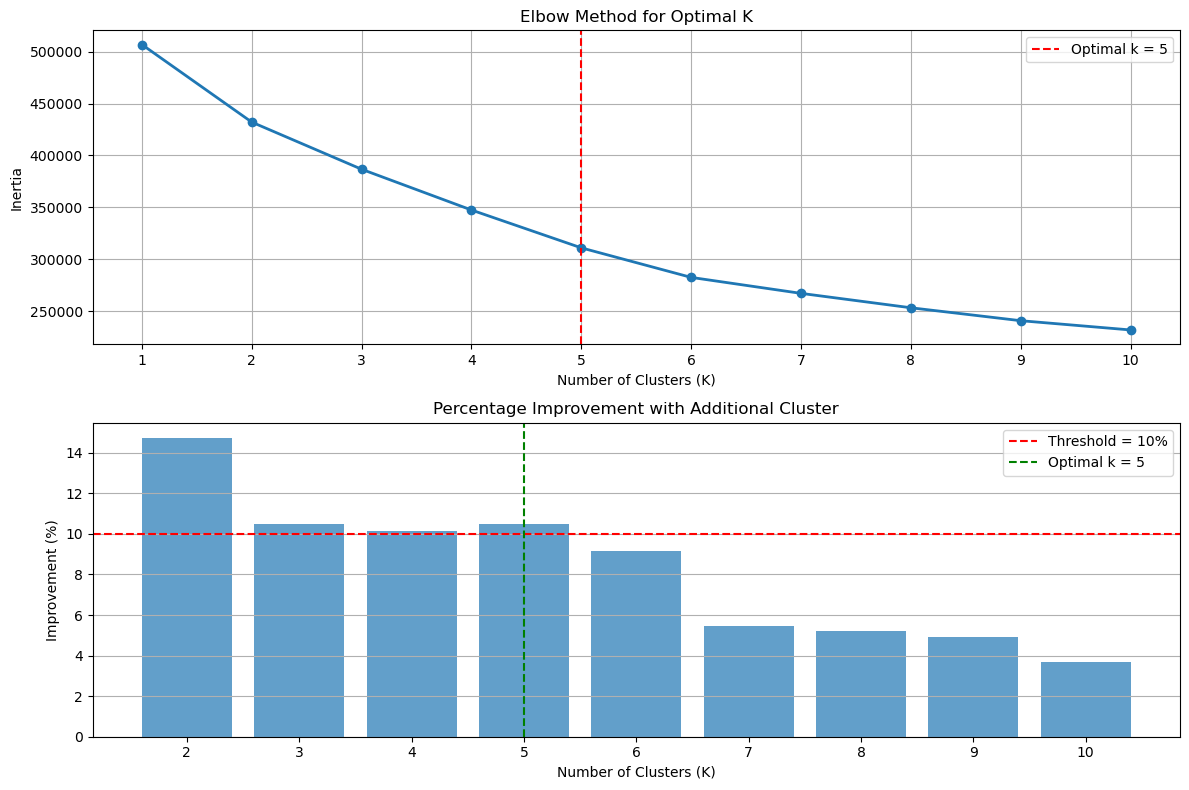

Automatically determined optimal k = 5 (last cluster with improvement >= 10%)


In [5]:
# Select numerical features for clustering
numerical_features = ['realSum', 'person_capacity', 'cleanliness_rating', 
                      'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
                      'host_is_superhost_bool', 'Is_weekend_bool','room_private_bool']

# Create a copy of the data with just numerical features
cluster_data = df[numerical_features].copy()

# Standardize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Find the elbow point using the rate of change
inertia_array = np.array(inertia)
# Calculate percentage of change in inertia
inertia_diffs = np.diff(inertia_array) / inertia_array[:-1] * 100
# Convert to absolute values (since changes are negative)
inertia_diffs_abs = np.abs(inertia_diffs)

# Find the last k value where improvement is above the threshold
threshold = 10  # percentage improvement threshold
optimal_k = 2  # default to 2 if no clear elbow

# Identify the last k value where the improvement is above threshold
last_above_threshold = None
for i, diff_pct in enumerate(inertia_diffs_abs):
    k_value = i + 2  # k value is i+2 (since we're looking at differences and k starts at 1)
    if diff_pct >= threshold:
        last_above_threshold = k_value

# Set optimal_k to be the last k with improvement above threshold
if last_above_threshold is not None:
    optimal_k = last_above_threshold  # Use exactly the last k above threshold

# Print the actual improvement percentages for clarity
print("Improvement percentages for each additional cluster:")
for i, pct in enumerate(inertia_diffs_abs):
    k_val = i + 2  # k starts at 2 for diffs
    print(f"  k={k_val}: {pct:.2f}% improvement")
    if k_val == last_above_threshold:
        print(f"  --> Last value above {threshold}% threshold")

# Plot the elbow curve
plt.figure(figsize=(12, 8))

# Main plot - inertia
plt.subplot(2, 1, 1)
plt.plot(k_range, inertia, marker='o', linewidth=2)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.legend()

# Secondary plot - percentage improvement
plt.subplot(2, 1, 2)
plt.bar(range(2, len(k_range) + 1), inertia_diffs_abs, alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}%')
# Mark the optimal k
plt.axvline(x=optimal_k, color='green', linestyle='--', 
           label=f'Optimal k = {optimal_k}')
plt.title('Percentage Improvement with Additional Cluster')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Improvement (%)')
plt.xticks(range(2, len(k_range) + 1))
plt.grid(True, axis='y')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Automatically determined optimal k = {optimal_k} (last cluster with improvement >= {threshold}%)")

In [9]:
optimal_k = 5  # Update this based on your elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

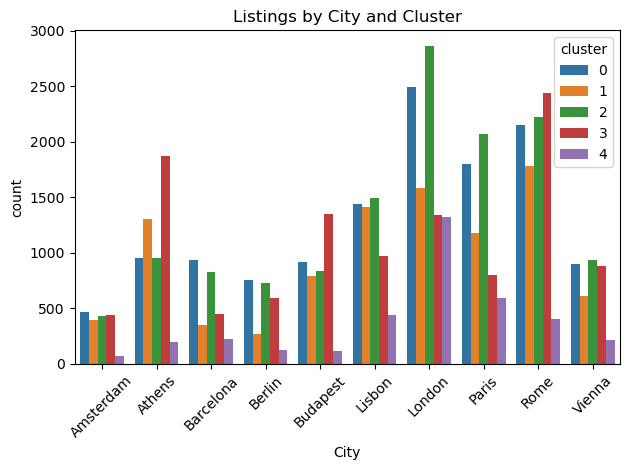

In [11]:
sns.countplot(data=df, x='City', hue='cluster')
plt.title("Listings by City and Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
cluster_summary = df.groupby('cluster')[numerical_features].mean()
cluster_summary
df['cluster'].value_counts().sort_index()


cluster
0    12809
1     9664
2    13357
3    11136
4     3711
Name: count, dtype: int64

In [ ]:
df = df.drop(columns=['cluster_4', 'cluster_6'], errors='ignore')  # `errors='ignore'` makes it safe if they don't exist
df.to_csv("../ML-exam/data/clustered_airbnb.csv", index=False)
